# iModulon Characterization:
# iModulons with KEGG Enrichements

## Setup
This IPython notebook continues from the initial iModulon Characterization notebook and will walk through the steps of characterizing iModulons through semi-automated tools, specifically through known KEGG enrichments (based on genes present in particular iModulons). You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import numpy as np
import re

from Bio.KEGG import REST
from tqdm.notebook import tqdm
from pymodulon.core import IcaData
from pymodulon.util import explained_variance
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.plotting import *


Bad key "text.kerning_factor" on line 4 in
/Users/siddharth/opt/miniconda3/envs/pymodulon/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# Load in metadata & TRN files
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')

# Load in other files to generate IcaData object
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_with_operons.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

### iModulon Table Setup (See Notebook 5a)

In [4]:
# Compute TRN enrichment, save enrichment data into imodulon table, rename long imod name to shorter one
ica_data.compute_regulon_enrichment(11,'XylR',save=True)
ica_data.compute_regulon_enrichment(12,'YtrA',save=True)
ica_data.compute_regulon_enrichment(13,'LysM',save=True)
ica_data.compute_regulon_enrichment(18,'tfb3',save=True)
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)
ica_data.compute_regulon_enrichment(29,'FadR',save=True)

reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})
ica_data.rename_imodulons({'XylR':'XylR-SoxM'})
ica_data.rename_imodulons({'tfb3':'UV-tfb3'})

# Add single_gene_imodulons and them to imodulon table
sg_imods = ica_data.find_single_gene_imodulons(save=True)
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# Rename 'single_gene_3' to FadR-KO
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

# Add E coli orthologs to imodulon table
ecoli_data = load_json_model('../example_data/example.json')
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../example_data/example_bbh.csv')

ica_data.imodulon_table['ecoli_ortholog'] = np.nan
for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

# Manually add complex orthologs
ica_data.imodulon_table.loc['XylR-SoxM', 'ecoli_ortholog'] = 'GlpR, crp-KO'
ica_data.imodulon_table.loc[23, 'ecoli_ortholog'] = 'CysB, translation'


ica_data.imodulon_table.loc[[2, 10, 'XylR-SoxM', 19, 20, 23, 25, 26, 'FadR', 38, 39]]

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PurR-1
XylR-SoxM,3.084629e-11,XylR,0.212766,0.370370,0.27027,10.0,27.0,47.0,1.0,NaN,"GlpR, crp-KO"
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArgR
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nac
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CysB, translation"
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fur-2
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NtrC+RpoN
FadR,1.349778e-37,FadR,0.760000,0.791667,0.77551,19.0,24.0,25.0,1.0,NaN,FadR/IclR
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NtrC+RpoN


---

## Characterize iModulons by KEGG Enrichments

These iModulons map closely to KEGG enrichment pathways and/or modules

In [5]:
# Load in KEGG enrichment tables
DF_pathway_enrich = pd.read_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'), index_col=0)
DF_module_enrich = pd.read_csv(path.join(data_dir,'kegg_module_enrichments.csv'), index_col=0)

DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

# Load in 1 block missing enrichment table
DF_1bm = pd.read_csv(path.join(data_dir, 'kegg_1bm_mapping.csv'), index_col=0)

In [6]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [7]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


In [8]:
# Custom function (will be useful for characterizing iModulons)
def get_kegg_enrichments(imodulon, kegg_type):
    if kegg_type == 'pathway':
        df = DF_pathway_enrich
    elif kegg_type == 'module':
        df = DF_module_enrich
    else:
        raise ValueError('kegg_type must be either "pathway" or "module"')
    
    cond = df['imodulon'].astype(str) == str(imodulon)
    return df[cond].dropna()

# Custom function to update kegg enrichments
def update_kegg_enrichments():
    DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
    DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

    for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
        text = REST.kegg_find('pathway',key).read()
        try:
            name = re.search('\t(.*)\n',text).group(1)
            DF_pathway_enrich.loc[idx,'pathway_name'] = name
        except AttributeError:
            DF_pathway_enrich.loc[idx,'pathway_name'] = None

    for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
        text = REST.kegg_find('module',key).read()
        try:
            name = re.search('\t(.*)\n',text).group(1)
            DF_module_enrich.loc[idx,'module_name'] = name
        except AttributeError:
            DF_module_enrich.loc[idx,'module_name'] = None
    
    return DF_pathway_enrich, DF_module_enrich

# Custom function to update iModulon Table with enriched KEGG pathways/modules/1-block-missing modules
def update_imodulon_table(imodulon, df):
    df = df.reset_index()
    ica_data.imodulon_table.loc[imodulon, 'pvalue'] = df.loc[0, 'pvalue']
    ica_data.imodulon_table.loc[imodulon, 'precision'] = df.loc[0, 'precision']
    ica_data.imodulon_table.loc[imodulon, 'recall'] = df.loc[0, 'recall']
    ica_data.imodulon_table.loc[imodulon, 'f1score'] = df.loc[0, 'f1score']
    ica_data.imodulon_table.loc[imodulon, 'TP'] = df.loc[0, 'TP']
    ica_data.imodulon_table.loc[imodulon, 'regulon_size'] = df.loc[0, 'target_set_size']
    ica_data.imodulon_table.loc[imodulon, 'imodulon_size'] = df.loc[0, 'imodulon_size']

In [9]:
p = set(DF_pathway_enrich.dropna()['imodulon'])
m = set(DF_module_enrich.dropna()['imodulon'])

print('Pathways only: ', p-m)
print('Modules only: ', m-p)
print('Pathways & Modules: ', p.intersection(m))

Pathways only:  {'39', '26', '25'}
Modules only:  set()
Pathways & Modules:  {'21', '10', 'XylR', '19', '31', '23', '4', '17', 'LysM', '7', '9'}


### iModulon 25: Cobalamin (Vit B12) iModulon [E coli Ortholog Fur-2]

In [10]:
get_kegg_enrichments(25, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
43,25,map02010,0.000013,0.002529,0.3,0.25,0.272727,3.0,12.0,10.0,ABC transporters


In [11]:
ica_data.rename_imodulons({25: 'Cobalamin'})

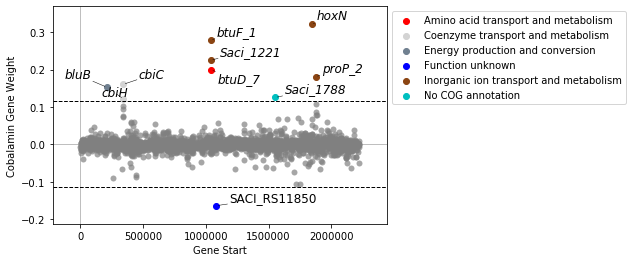

In [12]:
plot_gene_weights(ica_data, 'Cobalamin')

In [13]:
# Manually changing threshold yields more relevant enriched genes for this iModulon
# This is done as the threshold for enrichment is too conservative in this case
# (Allows for cbi operon to be enriched in this iModulon)
ica_data.change_threshold('Cobalamin', 0.07)

In [14]:
# Update KEGG enrichments (takes ~1 min to run)
DF_pathway_enrich, DF_module_enrich = update_kegg_enrichments()

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [15]:
get_kegg_enrichments('Cobalamin', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
43,Cobalamin,map00860,0.000100,0.019790,0.166667,0.16,0.163265,4.0,25.0,24.0,Porphyrin and chlorophyll metabolism
44,Cobalamin,map02010,0.000208,0.020462,0.125000,0.25,0.166667,3.0,12.0,24.0,ABC transporters


In [16]:
# Further inspection shows this iModulon closely follows
# 1-block-missing module for anaerobic cobalamin biosynthesis
compute = ica_data.compute_annotation_enrichment(DF_1bm[DF_1bm.kegg_id == 'sai_M00924'], 'kegg_id')
compute = compute[compute.imodulon == 'Cobalamin']
compute

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
1,Cobalamin,sai_M00924,1.894180e-09,1.894180e-09,0.25,0.428571,0.315789,6.0,14.0,24.0


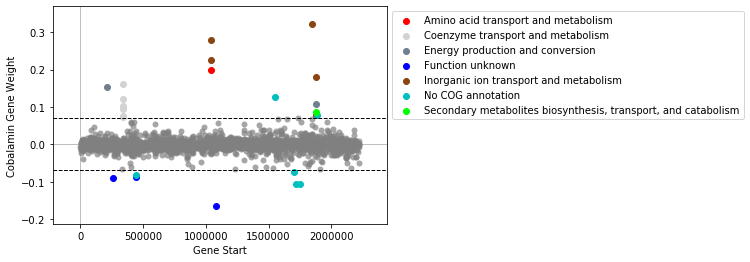

In [17]:
plot_gene_weights(ica_data, 'Cobalamin')

In [18]:
ica_data.view_imodulon('Cobalamin')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01220,0.152986,bluB,Saci_0250,Sacid_00247,NaN,209952,210617,+,"5,6-dimethylbenzimidazole synthase","5,6-dimethylbenzimidazole synthase",Energy production and conversion,A0A0U2X101,NC_007181.1,Op138,NaN
SACI_RS01470,-0.088996,Saci_0301,Saci_0301,Sacid_00297,NaN,256423,257034,-,DUF981 domain-containing protein,hypothetical protein,Function unknown,A0A0U3GQJ3,NC_007181.1,Op169,NaN
SACI_RS01930,0.074371,cbiF,Saci_0394,Sacid_00390,cobM,338070,338867,-,precorrin-4 C(11)-methyltransferase,Precorrin-4 C(11)-methyltransferase,Coenzyme transport and metabolism,A0A0U2WT12,NC_007181.1,Op227,NaN
SACI_RS01935,0.076971,cbiL,Saci_0395,Sacid_00391,cobI,338854,339525,-,cobalt-factor II C(20)-methyltransferase,hypothetical protein,Coenzyme transport and metabolism,A0A0U2Y0Z8,NC_007181.1,Op227,NaN
SACI_RS01940,0.094250,cbiT,Saci_0396,Sacid_00392,NaN,339522,340100,-,"precorrin-6Y C5,15-methyltransferase (decarbox...",Cobalt-precorrin-6B C(15)-methyltransferase (d...,Coenzyme transport and metabolism,A0A0U3GTE2,NC_007181.1,Op227,NaN
SACI_RS01945,0.103954,cbiD,Saci_0397,Sacid_00393,NaN,340097,341143,-,cobalt-precorrin-5B (C(1))-methyltransferase,Cobalt-precorrin-5B C(1)-methyltransferase,Coenzyme transport and metabolism,A0A0U3GUJ7,NC_007181.1,Op227,NaN
SACI_RS01950,0.121632,cbiH,Saci_0398,Sacid_00394,cobJ,341130,341885,-,precorrin-3B C(17)-methyltransferase,Cobalt-factor III methyltransferase,Coenzyme transport and metabolism,A0A0U3HBF9,NC_007181.1,Op227,NaN
SACI_RS01955,0.160739,cbiC,Saci_0399,Sacid_00395,cobH,341882,342883,-,precorrin-8X methylmutase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3H2U5,NC_007181.1,Op227,NaN
SACI_RS11540,-0.087980,SACI_RS11540,NaN,NaN,NaN,440182,440412,+,hypothetical protein,NaN,Function unknown,NaN,NC_007181.1,Op307,NaN
SACI_RS11800,-0.082741,SACI_RS11800,NaN,NaN,NaN,442246,442317,-,hypothetical protein,NaN,No COG annotation,NaN,NC_007181.1,Op310,NaN


In [19]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('Cobalamin', compute)

### iModulon 26: 4-hydroxyphenylacetate degradation iModulon [E coli ortholog: NtrC+RpoN]

- https://febs.onlinelibrary.wiley.com/doi/epdf/10.1111/febs.14105

In [20]:
ica_data.rename_imodulons({26: '4-HPA'})

In [21]:
get_kegg_enrichments(26, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
45,26,map01220,0.000166,0.032736,0.285714,0.285714,0.285714,2.0,7.0,7.0,Degradation of aromatic compounds


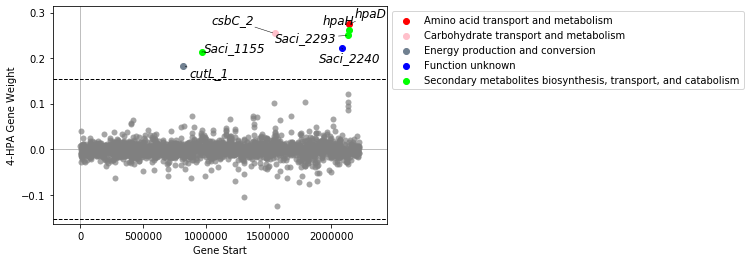

In [22]:
plot_gene_weights(ica_data, '4-HPA')

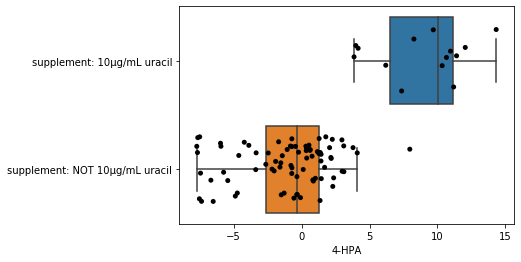

In [23]:
# Only NutLim project has supplement of 10 ug/mL uracil
# Suggests that this iModulon is upregulated in low-carbon conditions
metadata_boxplot(ica_data, '4-HPA', n_boxes=2)

In [24]:
ica_data.view_imodulon('4-HPA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS04870,0.182864,cutL_1,Saci_1020,Sacid_00993,NaN,819407,821452,+,xanthine dehydrogenase family protein molybdop...,Carbon monoxide dehydrogenase large chain,Energy production and conversion,A0A0U3H1B1,NC_007181.1,Op535,NaN
SACI_RS05500,0.213263,Saci_1155,Saci_1155,Sacid_01131,NaN,966891,967697,+,acetoacetate decarboxylase family protein,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",A0A0U2W2Q3,NC_007181.1,Op634,NaN
SACI_RS08525,0.254069,csbC_2,Saci_1782,Sacid_01749,NaN,1547302,1548780,-,MFS transporter,putative metabolite transport protein CsbC,Carbohydrate transport and metabolism,A0A0U2W123,NC_007181.1,Op1011,biofilm
SACI_RS10830,0.222119,Saci_2240,Saci_2240,Sacid_02241,NaN,2082950,2083417,-,flavin reductase family protein,Flavin reductase,Function unknown,A0A0U2Y2B5,NC_007181.1,Op1361,NaN
SACI_RS11095,0.249805,Saci_2293,Saci_2293,Sacid_02295,NaN,2136785,2137627,-,2-keto-4-pentenoate hydratase/2-oxohepta-3-ene...,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",Q4J6K3,NC_007181.1,Op1395,YtrA
SACI_RS11100,0.261034,hpaH,Saci_2294,Sacid_02296,hpaA,2137633,2139105,-,4-hydroxyphenylacetate 3-hydroxylase family pr...,Anthranilate 3-monooxygenase oxygenase component,"Secondary metabolites biosynthesis, transport,...",A0A0U2NGH6,NC_007181.1,Op1395,YtrA
SACI_RS11105,0.273739,hpaD,Saci_2295,Sacid_02297,bphC,2139102,2140043,-,"3,4-dihydroxyphenylacetate 2,3-dioxygenase, ca...","Manganese-dependent 2,3-dihydroxybiphenyl 1,2-...",Amino acid transport and metabolism,A0A0U3HN78,NC_007181.1,Op1395,YtrA


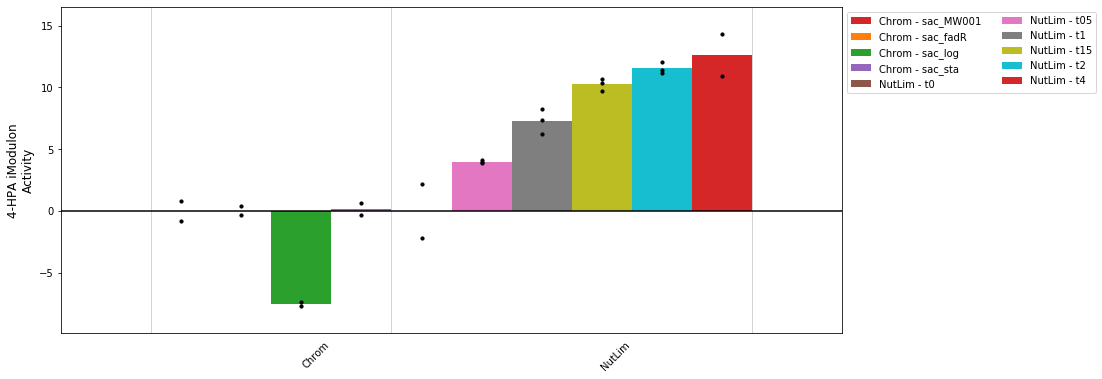

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, '4-HPA', projects=['Chrom', 'NutLim'], highlight=['Chrom', 'NutLim'], ax=ax)

### iModulon 39: Carotenoid Biosynthesis iModulon [E coli ortholog: GlpR]

### UV-related iModulon, Putative Vit B9 iModulon

In [26]:
get_kegg_enrichments(39, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
66,39,map00906,0.000143,0.028264,0.071429,1.0,0.133333,2.0,2.0,28.0,Carotenoid biosynthesis


In [27]:
ica_data.rename_imodulons({39: 'carotenoid'})

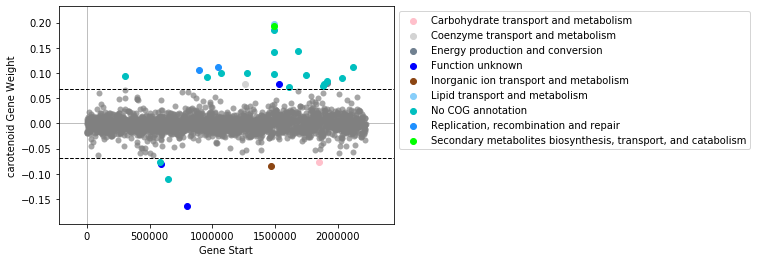

In [28]:
plot_gene_weights(ica_data, 'carotenoid')

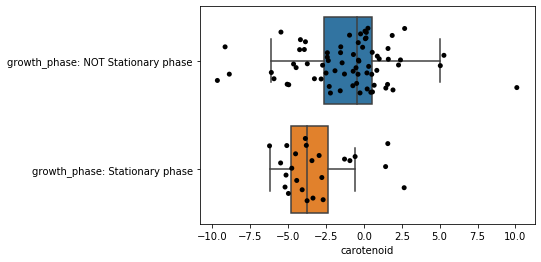

In [29]:
metadata_boxplot(ica_data, 'carotenoid', n_boxes=2)

In [30]:
ica_data.view_imodulon('carotenoid')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01760,0.094320,Saci_0360,Saci_0360,Sacid_00355,NaN,303121,304209,+,hypothetical protein,hypothetical protein,No COG annotation,M1ISI4,NC_007181.1,Op202,NaN
SACI_RS03460,-0.077127,SACI_RS03460,NaN,Sacid_00705,NaN,584094,584273,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FV95,NC_007181.1,Op387,NaN
SACI_RS11580,-0.079621,SACI_RS11580,NaN,NaN,NaN,594292,594510,+,integrase,NaN,Function unknown,NaN,NC_007181.1,Op397,NaN
SACI_RS11590,-0.109446,SACI_RS11590,NaN,NaN,NaN,648575,648803,+,hypothetical protein,NaN,No COG annotation,NaN,NC_007181.1,Op429,NaN
SACI_RS11630,-0.163157,SACI_RS11630,NaN,NaN,NaN,799347,799547,-,integrase,NaN,Function unknown,NaN,NC_007181.1,Op523,NaN
SACI_RS05225,0.105964,uvsE,Saci_1096,Sacid_01072,NaN,894785,895654,+,UV DNA damage repair endonuclease UvsE,UV DNA damage endonuclease,"Replication, recombination and repair",A0A0U3FU66,NC_007181.1,Op590,NaN
SACI_RS11845,0.092509,SACI_RS11845,NaN,NaN,NaN,955170,955289,+,molybdopterin-dependent oxidoreductase,NaN,No COG annotation,UPI0002B27A63,NC_007181.1,Op627,NaN
SACI_RS05850,0.111645,phrA,Saci_1227,Sacid_01204,NaN,1043234,1044526,+,deoxyribodipyrimidine photo-lyase,Deoxyribodipyrimidine photo-lyase,"Replication, recombination and repair",A0A0U3H8Q2,NC_007181.1,Op682,NaN
SACI_RS06010,0.100907,SACI_RS06010,NaN,Sacid_01236,NaN,1071231,1071434,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N8L9,NC_007181.1,Op707,NaN
SACI_RS07065,0.078118,folE,Saci_1481,Sacid_01448,NaN,1259620,1260249,+,GTP cyclohydrolase I FolE,GTP cyclohydrolase 1,Coenzyme transport and metabolism,A0A0U2VZN7,NC_007181.1,Op815,NaN


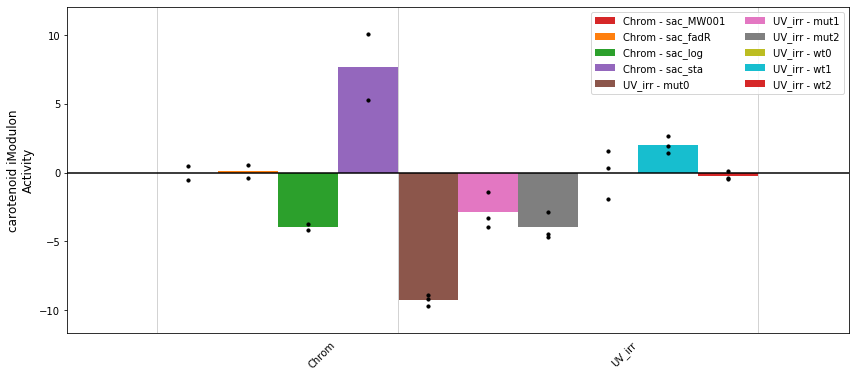

In [31]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'carotenoid',projects=['Chrom', 'UV_irr'], highlight=['Chrom', 'UV_irr'], ax=ax)

### iModulon 4: Riboflavin (Vit B2) iModulon

In [32]:
get_kegg_enrichments(4, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,0.000085,0.016746,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism


In [33]:
get_kegg_enrichments(4, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,0.000006,0.000968,0.333333,1.0,0.5,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."


In [34]:
ica_data.rename_imodulons({4: 'Riboflavin'})

In [35]:
# Further inspection shows a modified fungi Riboflavin module
# may be a better enrichment target
compute = ica_data.compute_annotation_enrichment(DF_1bm[DF_1bm.kegg_id == 'sai_M00911'], 'kegg_id')
compute

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,Riboflavin,sai_M00911,4.536369e-10,4.536369e-10,0.666667,0.571429,0.615385,4.0,7.0,6.0


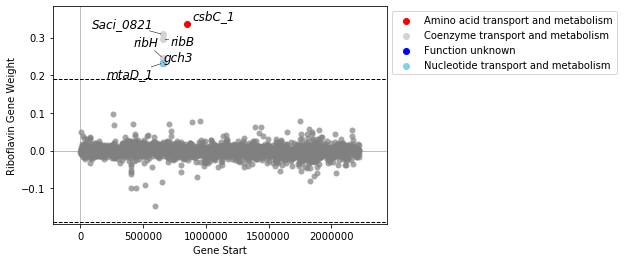

In [36]:
plot_gene_weights(ica_data, 'Riboflavin')

In [37]:
ica_data.view_imodulon('Riboflavin')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS03915,0.232396,mtaD_1,Saci_0818,Sacid_00797,NaN,656317,657420,-,amidohydrolase family protein,5-methylthioadenosine/S-adenosylhomocysteine d...,Nucleotide transport and metabolism,A0A0U2N979,NC_007181.1,Op433,NaN
SACI_RS03920,0.233548,gch3,Saci_0819,Sacid_00798,NaN,657402,658061,-,GTP cyclohydrolase IIa,hypothetical protein,Function unknown,A0A0U2Y7W8,NC_007181.1,Op433,NaN
SACI_RS03925,0.245319,ribH,Saci_0820,Sacid_00799,NaN,658058,658534,-,"6,7-dimethyl-8-ribityllumazine synthase","6,7-dimethyl-8-ribityllumazine synthase",Coenzyme transport and metabolism,UPI00005523C3,NC_007181.1,Op433,NaN
SACI_RS03930,0.308090,Saci_0821,Saci_0821,Sacid_00800,NaN,658506,658976,-,riboflavin synthase,hypothetical protein,Coenzyme transport and metabolism,A0A0U3FF10,NC_007181.1,Op433,NaN
SACI_RS03935,0.296197,ribB,Saci_0822,Sacid_00801,NaN,658973,659635,-,"3,4-dihydroxy-2-butanone-4-phosphate synthase","3,4-dihydroxy-2-butanone 4-phosphate synthase",Coenzyme transport and metabolism,A0A0U3F6Y4,NC_007181.1,Op433,NaN
SACI_RS04990,0.334581,csbC_1,Saci_1045,Sacid_01018,NaN,845538,846869,+,MFS transporter,putative metabolite transport protein CsbC,Amino acid transport and metabolism,A0A0U3FYG8,NC_007181.1,Op549,NaN


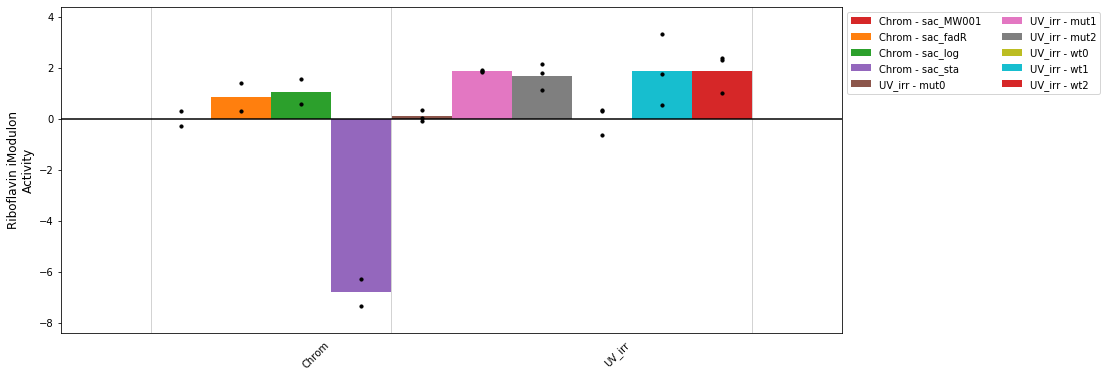

In [38]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Riboflavin', projects=['Chrom', 'UV_irr'], highlight=['Chrom', 'UV_irr'], ax=ax)

In [39]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('Riboflavin', compute)

### iModulon 7: Carbon Fixation iModulon (3-HP / 4-HB cycle)

Potentially related to biotin formation

Paper describing 3-HP / 4-HB cycle: https://sci-hub.se/https://science.sciencemag.org/content/318/5857/1782.full

Another paper on the subject (specific to Sulfolobales): https://sci-hub.se/10.1128/jb.01593-07


In [40]:
get_kegg_enrichments(7, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis
5,7,map00280,6.203662e-04,2.997886e-02,0.176471,0.125000,0.146341,3.0,24.0,17.0,"Valine, leucine and isoleucine degradation"
6,7,map00640,1.465411e-03,4.811434e-02,0.176471,0.093750,0.122449,3.0,32.0,17.0,Propanoate metabolism


In [41]:
get_kegg_enrichments(7, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."
5,7,M00526,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, DAP dehydrogenase pathway..."
6,7,M00527,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, DAP aminotransferase path..."
7,7,M00741,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Propanoyl-CoA metabolism, propanoyl-CoA => suc..."
8,7,M00016,1.060599e-03,2.003354e-02,0.117647,0.285714,0.166667,2.0,7.0,17.0,"Lysine biosynthesis, succinyl-DAP pathway, asp..."
9,7,M00017,1.060599e-03,2.003354e-02,0.117647,0.285714,0.166667,2.0,7.0,17.0,"Methionine biosynthesis, aspartate => homoseri..."
10,7,M00018,1.407975e-03,2.393557e-02,0.117647,0.250000,0.160000,2.0,8.0,17.0,"Threonine biosynthesis, aspartate => homoserin..."


In [42]:
ica_data.rename_imodulons({7: 'carbon-fixation'})

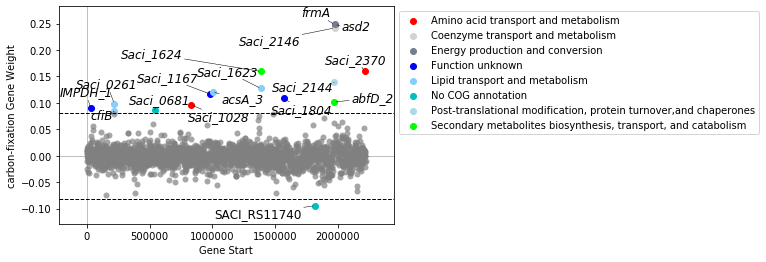

In [43]:
plot_gene_weights(ica_data, 'carbon-fixation')

In [44]:
ica_data.view_imodulon('carbon-fixation')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00195,0.090103,IMPDH_1,Saci_0044,Sacid_00042,NaN,29614,30108,+,CBS domain-containing protein,Inosine-5'-monophosphate dehydrogenase,Function unknown,A0A0U3GVE4,NC_007181.1,Op23,YtrA
SACI_RS01265,0.084405,cfiB,Saci_0260,Sacid_00256,pycA,217169,218701,+,Acetyl-CoA/propionyl-CoA carboxylase subunit a...,2-oxoglutarate carboxylase small subunit,Lipid transport and metabolism,A0A0U3H337,NC_007181.1,Op144,NaN
SACI_RS01270,0.098617,Saci_0261,Saci_0261,Sacid_00257,NaN,218701,219204,+,Acetyl-CoA/propionyl-CoA carboxylase subunit b...,hypothetical protein,Lipid transport and metabolism,A0A0U3GUX2,NC_007181.1,Op144,NaN
SACI_RS03240,0.086953,Saci_0681,Saci_0681,Sacid_00662,NaN,541758,542003,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3H9V2,NC_007181.1,Op364,NaN
SACI_RS04910,0.096804,Saci_1028,Saci_1028,Sacid_01002,argD,827654,828943,+,acetyl ornithine aminotransferase family protein,Acetylornithine aminotransferase,Amino acid transport and metabolism,A0A0U3HA02,NC_007181.1,Op541,NaN
SACI_RS05560,0.116667,Saci_1167,Saci_1167,Sacid_01144,NaN,983366,983848,-,CBS domain-containing protein,hypothetical protein,Function unknown,A0A0U3FLF0,NC_007181.1,Op642,NaN
SACI_RS05645,0.120481,acsA_3,Saci_1184,Sacid_01162,acs,1003003,1004967,-,3-Hydroxypropionate:CoA ligase (E4),Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3FLD5,NC_007181.1,Op654,NaN
SACI_RS07750,0.127476,Saci_1623,Saci_1623,Sacid_01588,lcdH,1386119,1387081,+,Malonate semialdehyde reductase (E3),L-carnitine dehydrogenase,Lipid transport and metabolism,A0A0U3HHE6,NC_007181.1,Op890,NaN
SACI_RS07755,0.159463,Saci_1624,Saci_1624,Sacid_01589,NaN,1387132,1387698,-,cupin domain-containing protein,hypothetical protein,"Secondary metabolites biosynthesis, transport,...",A0A0U3H0Q0,NC_007181.1,Op891,NaN
SACI_RS08640,0.108396,Saci_1804,Saci_1804,Sacid_01773,NaN,1571433,1571771,-,DUF2173 family protein,hypothetical protein,Function unknown,A0A0U2NBH2,NC_007181.1,Op1029,NaN


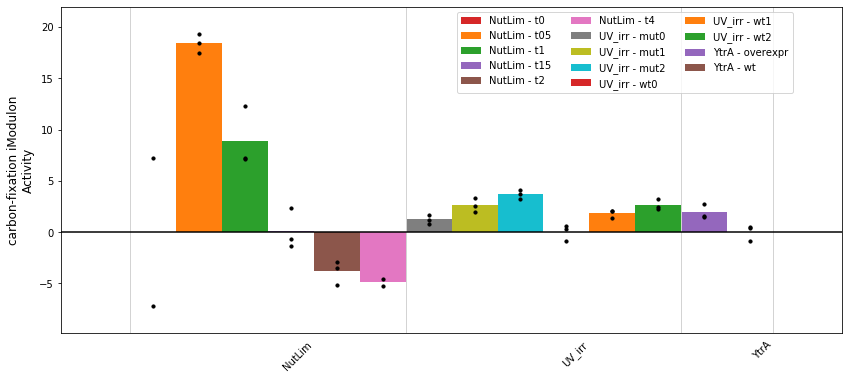

In [45]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'carbon-fixation', projects=['NutLim', 'UV_irr', 'YtrA'], 
                highlight=['NutLim', 'UV_irr', 'YtrA'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 1)})

In [46]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('carbon-fixation', get_kegg_enrichments(7, 'module').loc[[1]])

### iModulon 9: HMG-CoA iModulon

In [47]:
get_kegg_enrichments(9, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
7,9,map00900,0.000003,0.000543,0.6,0.187500,0.285714,3.0,16.0,5.0,Terpenoid backbone biosynthesis
8,9,map00072,0.000170,0.016707,0.4,0.200000,0.266667,2.0,10.0,5.0,Synthesis and degradation of ketone bodies
9,9,map00280,0.001028,0.067480,0.4,0.083333,0.137931,2.0,24.0,5.0,"Valine, leucine and isoleucine degradation"
10,9,map00650,0.001834,0.085801,0.4,0.062500,0.108108,2.0,32.0,5.0,Butanoate metabolism
11,9,map04976,0.002178,0.085801,0.2,1.000000,0.333333,1.0,1.0,5.0,Bile secretion


In [48]:
get_kegg_enrichments(9, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
11,9,M00095,0.000001,0.000240,0.6,0.230769,0.333333,3.0,13.0,5.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
12,9,M00088,0.000170,0.014417,0.4,0.200000,0.266667,2.0,10.0,5.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."


In [49]:
ica_data.rename_imodulons({9: 'HMG-CoA'})

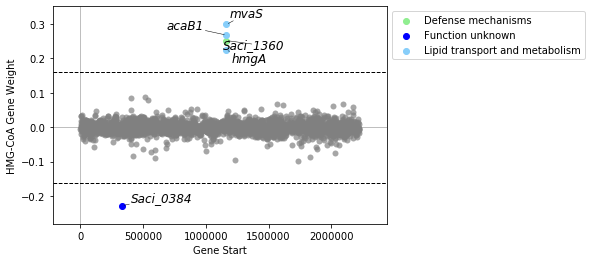

In [50]:
plot_gene_weights(ica_data, 'HMG-CoA')

In [51]:
ica_data.view_imodulon('HMG-CoA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01880,-0.228067,Saci_0384,Saci_0384,Sacid_00380,NaN,331631,331996,+,DUF2203 domain-containing protein,hypothetical protein,Function unknown,A0A0U3HEK3,NC_007181.1,Op219,aCPSF2-stat
SACI_RS06500,0.224299,hmgA,Saci_1359,Sacid_01333,NaN,1161400,1162635,-,hydroxymethylglutaryl-CoA reductase (NADPH),hypothetical protein,Lipid transport and metabolism,A0A0U3FV32,NC_007181.1,Op755,NaN
SACI_RS06505,0.252092,Saci_1360,Saci_1360,Sacid_01334,NaN,1162619,1163032,-,Zn-ribbon domain-containing OB-fold protein,hypothetical protein,Defense mechanisms,A0A0U3H6A0,NC_007181.1,Op755,NaN
SACI_RS06510,0.267876,acaB1,Saci_1361,Sacid_01335,NaN,1163038,1164132,-,thiolase family protein,hypothetical protein,Lipid transport and metabolism,A0A0U2Y6H3,NC_007181.1,Op755,NaN
SACI_RS06515,0.298705,mvaS,Saci_1362,Sacid_01336,NaN,1164132,1165178,-,hydroxymethylglutaryl-CoA synthase,Hydroxymethylglutaryl-CoA synthase,Lipid transport and metabolism,A0A0U3H6B3,NC_007181.1,Op755,NaN


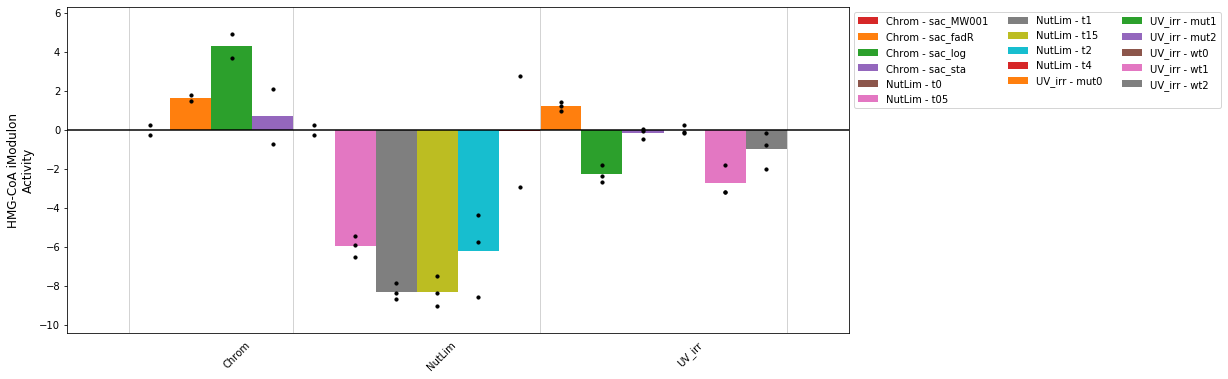

In [52]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'HMG-CoA', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

In [53]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('HMG-CoA', get_kegg_enrichments(9, 'module').loc[[11]])

### iModulon 10: Purine biosynthesis iModulon [E coli ortholog: PurR-1]

In [54]:
get_kegg_enrichments(10, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
13,10,map00230,4.706404e-08,0.000009,0.714286,0.111111,0.192308,5.0,45.0,7.0,Purine metabolism
15,10,map01110,4.260217e-05,0.002798,0.714286,0.028902,0.055556,5.0,173.0,7.0,Biosynthesis of secondary metabolites


In [55]:
get_kegg_enrichments(10, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
13,10,M00048,5.075523e-11,8.628390e-09,0.714286,0.384615,0.5,5.0,13.0,7.0,"Inosine monophosphate biosynthesis, PRPP + glu..."


In [56]:
ica_data.rename_imodulons({10: 'Purine'})

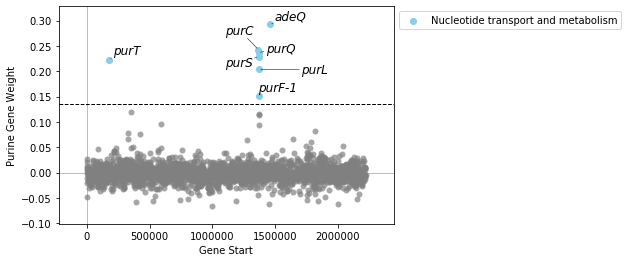

In [57]:
plot_gene_weights(ica_data, 'Purine')

In [58]:
# Manually changing threshold yields more relevant enriched genes for this iModulon
# This is done as the threshold for enrichment is too conservative in this case
ica_data.change_threshold('Purine', 0.08)

In [59]:
# Update KEGG enrichments
DF_pathway_enrich, DF_module_enrich = update_kegg_enrichments()

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [60]:
get_kegg_enrichments('Purine', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
13,Purine,map00230,1.244107e-13,2.450890e-11,0.692308,0.200000,0.310345,9.0,45.0,13.0,Purine metabolism
15,Purine,map01110,8.249522e-07,5.417186e-05,0.615385,0.046243,0.086022,8.0,173.0,13.0,Biosynthesis of secondary metabolites
16,Purine,map01100,4.162492e-05,2.050027e-03,0.692308,0.023018,0.044554,9.0,391.0,13.0,Metabolic pathways


In [61]:
get_kegg_enrichments('Purine', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
13,Purine,M00048,8.669205e-17,1.473765e-14,0.615385,0.615385,0.615385,8.0,13.0,13.0,"Inosine monophosphate biosynthesis, PRPP + glu..."


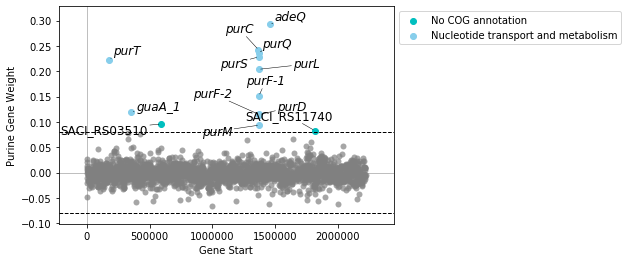

In [62]:
plot_gene_weights(ica_data, 'Purine')

In [63]:
ica_data.view_imodulon('Purine')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01035,0.222913,purT,Saci_0214,Sacid_00208,NaN,176428,177624,-,formate-dependent phosphoribosylglycinamide fo...,Formate-dependent phosphoribosylglycinamide fo...,Nucleotide transport and metabolism,A0A0U3FGE0,NC_007181.1,Op112,NaN
SACI_RS02020,0.119964,guaA_1,Saci_0414,Sacid_00409,NaN,354525,355646,+,7-cyano-7-deazaguanine synthase,GMP synthase [glutamine-hydrolyzing],Nucleotide transport and metabolism,A0A0U3FP39,NC_007181.1,Op234,NaN
SACI_RS03510,0.095766,SACI_RS03510,NaN,Sacid_00716,NaN,590261,590485,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2N9C5,NC_007181.1,Op394,NaN
SACI_RS07670,0.242352,purC,Saci_1607,Sacid_01572,NaN,1368285,1368992,+,phosphoribosylaminoimidazolesuccinocarboxamide...,Phosphoribosylaminoimidazole-succinocarboxamid...,Nucleotide transport and metabolism,A0A0U3GPL6,NC_007181.1,Op885,NaN
SACI_RS07675,0.228183,purS,Saci_1608,Sacid_01573,NaN,1368989,1369267,+,phosphoribosylformylglycinamidine synthase sub...,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U3H6I0,NC_007181.1,Op885,NaN
SACI_RS07680,0.236846,purQ,NaN,Sacid_01574,NaN,1369248,1369928,+,phosphoribosylformylglycinamidine synthase I,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U2WXT4,NC_007181.1,Op885,NaN
SACI_RS07685,0.203736,purL,Saci_1610,Sacid_01575,NaN,1369918,1372050,+,phosphoribosylformylglycinamidine synthase sub...,Phosphoribosylformylglycinamidine synthase sub...,Nucleotide transport and metabolism,A0A0U2Y5V4,NC_007181.1,Op885,NaN
SACI_RS07690,0.151333,purF-1,Saci_1611,Sacid_01576,purF,1372043,1373377,+,amidophosphoribosyltransferase,Amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0U3H7S7,NC_007181.1,Op885,NaN
SACI_RS07695,0.114578,purF-2,Saci_1612,Sacid_01577,NaN,1373383,1374597,+,amidophosphoribosyltransferase,Amidophosphoribosyltransferase,Nucleotide transport and metabolism,A0A0U3HDH6,NC_007181.1,Op885,NaN
SACI_RS07700,0.114411,purD,Saci_1613,Sacid_01578,NaN,1374603,1376039,+,phosphoribosylamine--glycine ligase,Phosphoribosylamine--glycine ligase,Nucleotide transport and metabolism,A0A0U3FBU2,NC_007181.1,Op885,NaN


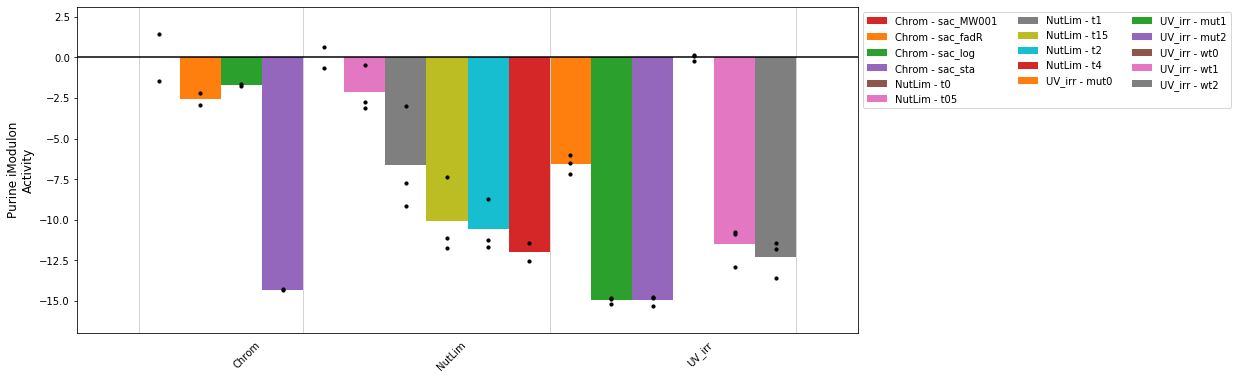

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Purine', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

In [65]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('Purine', get_kegg_enrichments('Purine', 'module').loc[[13]])

### iModulon 17: Translation iModulon 1

### Putative Composite iModulon (Translation + Cell Division + Shikimate iModulon)

In [66]:
get_kegg_enrichments(17, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
35,17,map03010,5.303780e-09,0.000001,0.139344,0.278689,0.185792,17.0,61.0,122.0,Ribosome


In [67]:
get_kegg_enrichments(17, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
27,17,M00022,0.000235,0.013298,0.032787,0.571429,0.062016,4.0,7.0,122.0,"Shikimate pathway, phosphoenolpyruvate + eryth..."


In [68]:
ica_data.rename_imodulons({17: 'translation-1'})

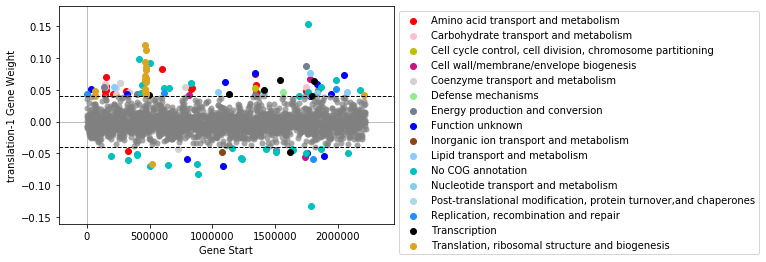

In [69]:
plot_gene_weights(ica_data, 'translation-1')

- Most likely a composite iModulon consisting of some of the following:
- Translation/Ribosome iModulon
- Cell division iModulon
- Shikimate/ Aromatic AA iModulon

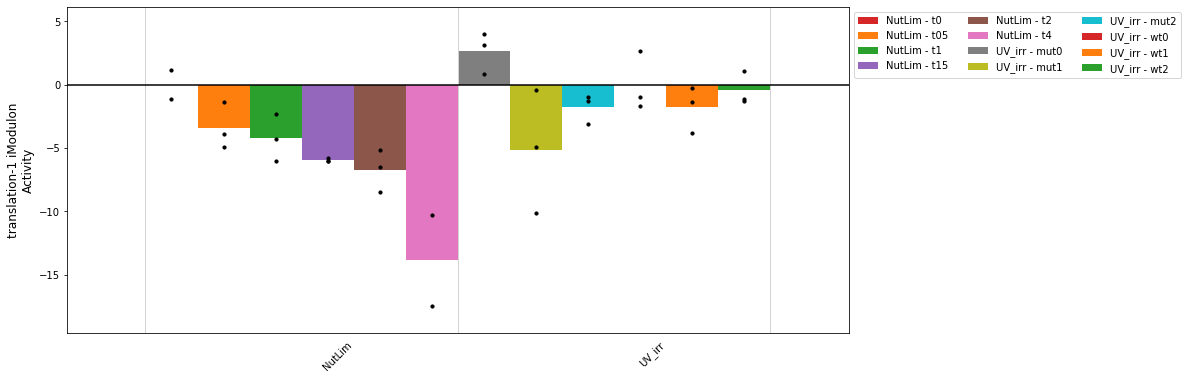

In [70]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-1', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

In [71]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('translation-1', get_kegg_enrichments(17, 'pathway').loc[[35]])

### iModulon 19: Arginine biosynthesis iModulon [E coli ortholog: ArgR]

In [72]:
get_kegg_enrichments(19, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
36,19,map00250,5.182310e-09,0.000001,1.0,0.190476,0.320000,4.0,21.0,4.0,"Alanine, aspartate and glutamate metabolism"
37,19,map00220,1.764982e-04,0.017385,0.5,0.153846,0.235294,2.0,13.0,4.0,Arginine biosynthesis
38,19,map01100,8.303681e-04,0.054528,1.0,0.010230,0.020253,4.0,391.0,4.0,Metabolic pathways
39,19,map00240,1.180873e-03,0.058158,0.5,0.060606,0.108108,2.0,33.0,4.0,Pyrimidine metabolism


In [73]:
get_kegg_enrichments(19, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
28,19,M00029,0.000007,0.000387,0.5,0.666667,0.571429,2.0,3.0,4.0,Urea cycle
29,19,M00844,0.000007,0.000387,0.5,0.666667,0.571429,2.0,3.0,4.0,"Arginine biosynthesis, ornithine => arginine"
30,19,M00845,0.000002,0.000387,0.5,1.000000,0.666667,2.0,2.0,4.0,"Arginine biosynthesis, glutamate => acetylcitr..."
31,19,M00051,0.000064,0.002701,0.5,0.250000,0.333333,2.0,8.0,4.0,"Uridine monophosphate biosynthesis, glutamine ..."


In [74]:
ica_data.rename_imodulons({19: 'Arginine'})

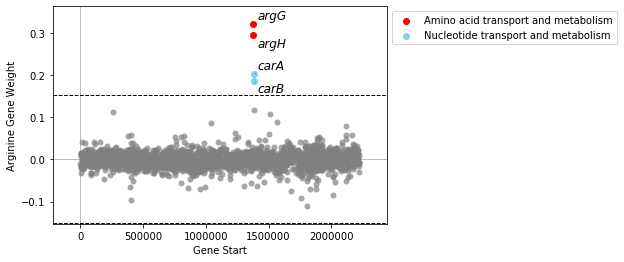

In [75]:
plot_gene_weights(ica_data, 'Arginine')

In [76]:
# Threshold is lowered again in this case to allow for argX
# This threshold is also too conservative which is why it was lowered
ica_data.change_threshold('Arginine', 0.1)

In [77]:
# Update KEGG enrichments
DF_pathway_enrich, DF_module_enrich = update_kegg_enrichments()

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [78]:
get_kegg_enrichments('Arginine', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
36,Arginine,map00250,3.542265e-07,0.00007,0.500,0.190476,0.275862,4.0,21.0,8.0,"Alanine, aspartate and glutamate metabolism"
37,Arginine,map00220,7.820623e-06,0.00077,0.375,0.230769,0.285714,3.0,13.0,8.0,Arginine biosynthesis


In [79]:
get_kegg_enrichments('Arginine', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
28,Arginine,M00029,0.000032,0.001804,0.25,0.666667,0.363636,2.0,3.0,8.0,Urea cycle
29,Arginine,M00844,0.000032,0.001804,0.25,0.666667,0.363636,2.0,3.0,8.0,"Arginine biosynthesis, ornithine => arginine"
30,Arginine,M00845,0.000011,0.001804,0.25,1.000000,0.400000,2.0,2.0,8.0,"Arginine biosynthesis, glutamate => acetylcitr..."
31,Arginine,M00051,0.000294,0.012515,0.25,0.250000,0.250000,2.0,8.0,8.0,"Uridine monophosphate biosynthesis, glutamine ..."


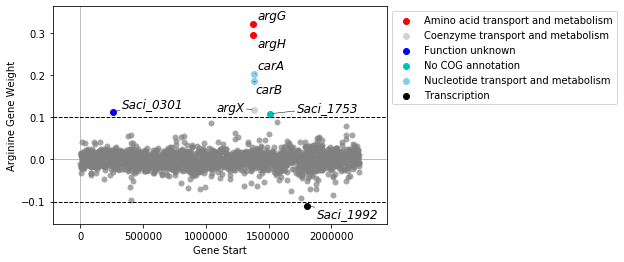

In [80]:
plot_gene_weights(ica_data, 'Arginine')

In [81]:
ica_data.view_imodulon('Arginine')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01470,0.112533,Saci_0301,Saci_0301,Sacid_00297,NaN,256423,257034,-,DUF981 domain-containing protein,hypothetical protein,Function unknown,A0A0U3GQJ3,NC_007181.1,Op169,NaN
SACI_RS07720,0.319741,argG,Saci_1617,Sacid_01582,NaN,1377839,1379014,+,argininosuccinate synthase,Argininosuccinate synthase,Amino acid transport and metabolism,A0A0U2WVT6,NC_007181.1,Op888,NaN
SACI_RS07725,0.295475,argH,Saci_1618,Sacid_01583,NaN,1379015,1380358,+,argininosuccinate lyase,Argininosuccinate lyase,Amino acid transport and metabolism,A0A0U2Y3V1,NC_007181.1,Op888,NaN
SACI_RS07730,0.201726,carA,Saci_1619,Sacid_01584,pyrA,1380339,1381454,+,carbamoyl-phosphate synthase (glutamine-hydrol...,Carbamoyl-phosphate synthase small chain,Nucleotide transport and metabolism,A0A0U3FKU8,NC_007181.1,Op888,NaN
SACI_RS07735,0.185377,carB,Saci_1620,Sacid_01585,NaN,1381447,1384605,+,carbamoyl-phosphate synthase (glutamine-hydrol...,Carbamoyl-phosphate synthase large chain,Nucleotide transport and metabolism,A0A0U3FCR2,NC_007181.1,Op888,NaN
SACI_RS07740,0.117638,argX,Saci_1621,Sacid_01586,"lysX, lysX_3",1384602,1385450,+,Glutamate--LysW ligase ArgX,Alpha-aminoadipate--LysW ligase LysX,Coenzyme transport and metabolism,A0A0U3GQD8,NC_007181.1,Op888,NaN
SACI_RS08380,0.108080,Saci_1753,Saci_1753,Sacid_01717,NaN,1511477,1511761,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FSN3,NC_007181.1,Op989,NaN
SACI_RS09635,-0.109902,Saci_1992,Saci_1992,Sacid_01984,NaN,1809967,1810347,-,winged helix-turn-helix transcriptional regula...,hypothetical protein,Transcription,A0A0U3H4P9,NC_007181.1,Op1183,NaN


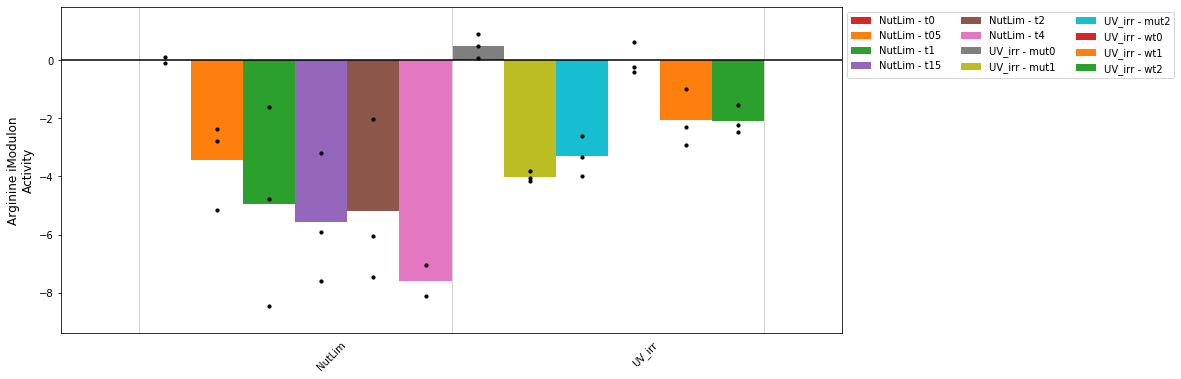

In [82]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Arginine', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

In [83]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('Arginine', get_kegg_enrichments('Arginine', 'pathway').loc[[37]])

### iModulon 21: Translation iModulon 2
### Putative Composite iModulon (Translation + Cell Division + Porphyrin iModulon)

In [84]:
get_kegg_enrichments(21, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
38,21,map03010,1.734450e-09,3.416866e-07,0.130137,0.311475,0.183575,19.0,61.0,146.0,Ribosome
39,21,map00970,2.307675e-04,2.273060e-02,0.054795,0.285714,0.091954,8.0,28.0,146.0,Aminoacyl-tRNA biosynthesis


In [85]:
get_kegg_enrichments(21, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
34,21,M00121,0.000047,0.002641,0.034247,0.625000,0.064935,5.0,8.0,146.0,"Heme biosynthesis, plants and bacteria, glutam..."
37,21,M00159,0.000473,0.013394,0.027397,0.571429,0.052288,4.0,7.0,146.0,"V/A-type ATPase, prokaryotes"
38,21,M00051,0.000899,0.021830,0.027397,0.500000,0.051948,4.0,8.0,146.0,"Uridine monophosphate biosynthesis, glutamine ..."


In [86]:
ica_data.rename_imodulons({21: 'translation-2'})

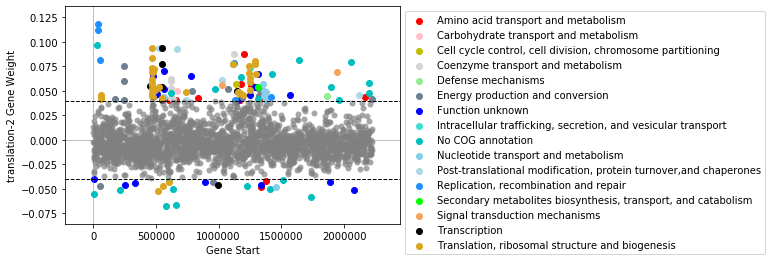

In [87]:
plot_gene_weights(ica_data, 'translation-2')

Most likely a composite iModulon consisting of some of the following:
- Translation/Ribosome iModulon (specifically including aa-tRNA)
- Cell division iModulon

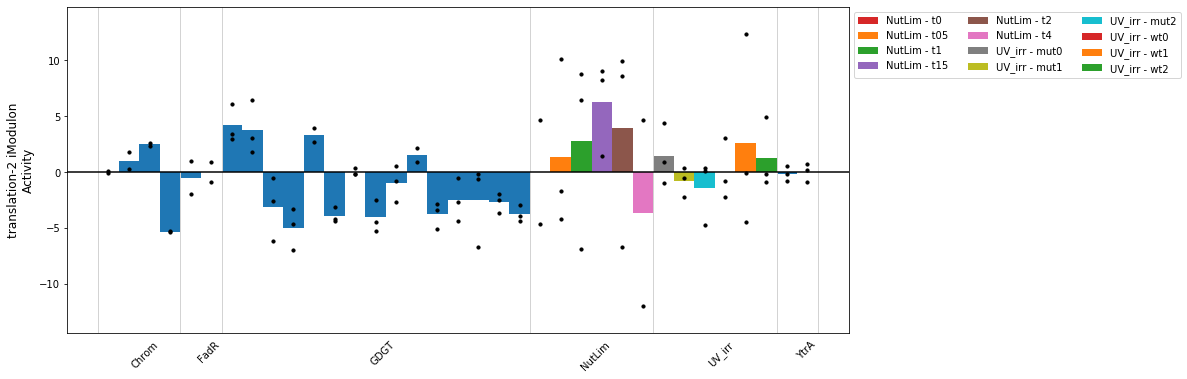

In [88]:
# Very messy activities for this iModulon (esp in NutLim project)
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-2', highlight=['NutLim', 'UV_irr'], ax=ax)

In [89]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('translation-2', get_kegg_enrichments(21, 'pathway').loc[[38]])

### iModulon 23: Sulfur Assimilation iModulon [E coli Ortholog: CysB, translation]

In [90]:
get_kegg_enrichments(23, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
40,23,map00920,7.583891e-09,0.000001,0.500,0.444444,0.470588,4.0,9.0,8.0,Sulfur metabolism
41,23,map01120,5.148720e-05,0.005071,0.625,0.033557,0.063694,5.0,149.0,8.0,Microbial metabolism in diverse environments


In [91]:
get_kegg_enrichments(23, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
39,23,M00176,2.779658e-08,0.000005,0.375,1.0,0.545455,3.0,3.0,8.0,"Assimilatory sulfate reduction, sulfate => H2S"


In [92]:
ica_data.rename_imodulons({23: 'sulfur-assimilation'})

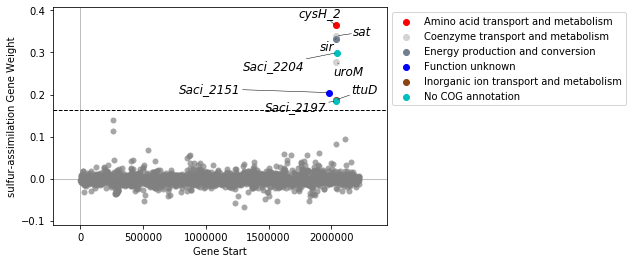

In [93]:
plot_gene_weights(ica_data, 'sulfur-assimilation')

In [94]:
ica_data.change_threshold('sulfur-assimilation', 0.1)

In [95]:
# Update KEGG enrichments
DF_pathway_enrich, DF_module_enrich = update_kegg_enrichments()

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [96]:
get_kegg_enrichments('sulfur-assimilation', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
40,sulfur-assimilation,map00920,2.267223e-08,0.000004,0.4,0.444444,0.421053,4.0,9.0,10.0,Sulfur metabolism
41,sulfur-assimilation,map01120,2.081559e-04,0.020503,0.5,0.033557,0.062893,5.0,149.0,10.0,Microbial metabolism in diverse environments


In [97]:
get_kegg_enrichments('sulfur-assimilation', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
39,sulfur-assimilation,M00176,5.956409e-08,0.00001,0.3,1.0,0.461538,3.0,3.0,10.0,"Assimilatory sulfate reduction, sulfate => H2S"


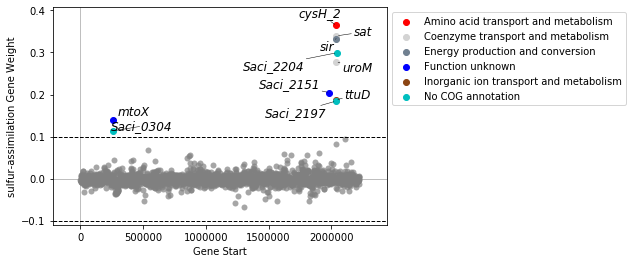

In [98]:
plot_gene_weights(ica_data, 'sulfur-assimilation')

In [99]:
ica_data.view_imodulon('sulfur-assimilation')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01485,0.113377,Saci_0304,Saci_0304,Sacid_00300,NaN,258506,259060,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2Y921,NC_007181.1,Op172,NaN
SACI_RS01490,0.139991,mtoX,Saci_0305,Sacid_00301,NaN,259029,260429,-,selenium-binding family protein,Methanethiol oxidase,Function unknown,A0A0U3HAR4,NC_007181.1,Op172,NaN
SACI_RS10405,0.204526,Saci_2151,Saci_2151,Sacid_02149,NaN,1983935,1984822,+,sulfite exporter TauE/SafE family protein,hypothetical protein,Function unknown,A0A0U3GUX1,NC_007181.1,Op1293,"hypotonic-K,hypotonic-Na,hypotonic-all"
SACI_RS10620,0.184260,Saci_2197,Saci_2197,Sacid_02197,NaN,2036205,2036453,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2VXH2,NC_007181.1,Op1329,aCPSF2-stat
SACI_RS10625,0.187108,ttuD,Saci_2198,Sacid_02198,NaN,2036450,2037328,-,sulfurtransferase,Sulfur carrier protein TtuD,Inorganic ion transport and metabolism,A0A0U2YA58,NC_007181.1,Op1329,NaN
SACI_RS10635,0.277858,uroM,Saci_2200,Sacid_02200,cysG_2,2037777,2038472,-,uroporphyrinogen-III C-methyltransferase,Siroheme synthase,Coenzyme transport and metabolism,A0A0U2NCI9,NC_007181.1,Op1331,"hypotonic-Na,hypotonic-all,Saci_1955"
SACI_RS10640,0.332837,sir,Saci_2201,Sacid_02201,NaN,2038462,2040240,-,nitrite/sulfite reductase,Sulfite reductase [ferredoxin],Energy production and conversion,A0A0U2Y2E5,NC_007181.1,Op1331,NaN
SACI_RS10645,0.364198,cysH_2,Saci_2202,Sacid_02202,NaN,2040367,2041086,-,"phosphoadenylyl-sulfate reductase, 5′-adenylyl...",Thioredoxin-dependent 5'-adenylylsulfate reduc...,Amino acid transport and metabolism,A0A0U2X312,NC_007181.1,Op1332,NaN
SACI_RS10650,0.339466,sat,Saci_2203,Sacid_02203,NaN,2041202,2042437,+,sulfate adenylyltransferase,Sulfate adenylyltransferase,Coenzyme transport and metabolism,A0A0U3FXL2,NC_007181.1,Op1333,NaN
SACI_RS10655,0.299234,Saci_2204,Saci_2204,Sacid_02204,NaN,2042434,2042739,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2NGN4,NC_007181.1,Op1333,NaN


In [100]:
# Update iModulon Table with KEGG enrichment
#update_imodulon_table('sulfur-assimilation', get_kegg_enrichments('sulfur-assimilation', 'pathway').loc[[40]])

### iModulon 31: TCA intermediates / BCAA metabolism iModulon [ E coli ortholog: Lrp]
### Putative Carbon/Nitrogen Fixation iModulon

-https://sci-hub.se/https://www.nature.com/articles/nrmicro2365


In [101]:
get_kegg_enrichments(31, 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
45,31,map00633,2.649602e-09,5.219716e-07,0.222222,1.000000,0.363636,4.0,4.0,18.0,Nitrotoluene degradation
46,31,map00620,7.801612e-09,7.684587e-07,0.388889,0.175000,0.241379,7.0,40.0,18.0,Pyruvate metabolism
47,31,map00650,7.399756e-08,4.859173e-06,0.333333,0.187500,0.240000,6.0,32.0,18.0,Butanoate metabolism
48,31,map00290,1.261122e-06,6.211026e-05,0.222222,0.333333,0.266667,4.0,12.0,18.0,"Valine, leucine and isoleucine biosynthesis"
49,31,map00010,3.362287e-06,1.103951e-04,0.277778,0.151515,0.196078,5.0,33.0,18.0,Glycolysis / Gluconeogenesis
50,31,map00640,2.866491e-06,1.103951e-04,0.277778,0.156250,0.200000,5.0,32.0,18.0,Propanoate metabolism
51,31,map00020,2.137427e-05,6.015330e-04,0.222222,0.173913,0.195122,4.0,23.0,18.0,Citrate cycle (TCA cycle)
52,31,map01210,3.555836e-05,8.756246e-04,0.222222,0.153846,0.181818,4.0,26.0,18.0,2-Oxocarboxylic acid metabolism
53,31,map00680,6.391307e-05,1.398986e-03,0.222222,0.133333,0.166667,4.0,30.0,18.0,Methane metabolism
55,31,map01100,2.202632e-04,3.944714e-03,0.555556,0.025575,0.048900,10.0,391.0,18.0,Metabolic pathways


In [102]:
get_kegg_enrichments(31, 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
41,31,M00307,3.935652e-08,0.000007,0.222222,0.666667,0.333333,4.0,6.0,18.0,"Pyruvate oxidation, pyruvate => acetyl-CoA"
42,31,M00620,1.261122e-06,0.000107,0.222222,0.333333,0.266667,4.0,12.0,18.0,"Incomplete reductive citrate cycle, acetyl-CoA..."
43,31,M00173,1.186849e-05,0.000673,0.222222,0.200000,0.210526,4.0,20.0,18.0,Reductive citrate cycle (Arnon-Buchanan cycle)
44,31,M00374,7.302165e-05,0.003103,0.222222,0.129032,0.163265,4.0,31.0,18.0,Dicarboxylate-hydroxybutyrate cycle
45,31,M00019,5.726591e-04,0.019470,0.111111,0.400000,0.173913,2.0,5.0,18.0,"Valine/isoleucine biosynthesis, pyruvate => va..."
46,31,M00432,8.549976e-04,0.020764,0.111111,0.333333,0.166667,2.0,6.0,18.0,"Leucine biosynthesis, 2-oxoisovalerate => 2-ox..."
47,31,M00570,8.549976e-04,0.020764,0.111111,0.333333,0.166667,2.0,6.0,18.0,"Isoleucine biosynthesis, threonine => 2-oxobut..."


In [103]:
ica_data.rename_imodulons({31: 'TCA-BCAA'})

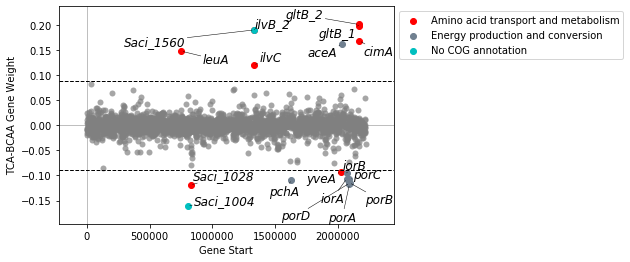

In [104]:
plot_gene_weights(ica_data, 'TCA-BCAA')

In [105]:
ica_data.view_imodulon('TCA-BCAA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS04490,0.147968,leuA,Saci_0940,Sacid_00916,IPMS,753048,754208,+,"2-isopropylmalate synthase, Homoacontiate hydr...",2-isopropylmalate synthase,Amino acid transport and metabolism,A0A0U3GS85,NC_007181.1,Op495,NaN
SACI_RS04795,-0.160334,Saci_1004,Saci_1004,Sacid_00978,NaN,805226,805438,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FLQ2,NC_007181.1,Op526,NaN
SACI_RS04910,-0.118874,Saci_1028,Saci_1028,Sacid_01002,argD,827654,828943,+,acetyl ornithine aminotransferase family protein,Acetylornithine aminotransferase,Amino acid transport and metabolism,A0A0U3HA02,NC_007181.1,Op541,NaN
SACI_RS07430,0.120230,ilvC,Saci_1559,Sacid_01524,NaN,1331979,1332977,-,Ketol-acid reductoisomerase (NADP(+)),Ketol-acid reductoisomerase (NAD(+)),Amino acid transport and metabolism,A0A0U3H6N8,NC_007181.1,Op858,NaN
SACI_RS07435,0.190334,Saci_1560,Saci_1560,Sacid_01525,NaN,1332958,1333353,-,ACT domain-containing protein,hypothetical protein,No COG annotation,A0A0U3FUK9,NC_007181.1,Op858,NaN
SACI_RS07440,0.191019,ilvB_2,Saci_1561,Sacid_01526,NaN,1333331,1335049,-,acetolactate synthase large subunit (branched AA),Acetolactate synthase large subunit,Amino acid transport and metabolism,A0A0U3GJG7,NC_007181.1,Op858,NaN
SACI_RS08920,-0.109200,pchA,Saci_1857,Sacid_01827,NaN,1631234,1632679,-,aldehyde dehydrogenase family protein,4-hydroxybenzaldehyde dehydrogenase (NADP(+)),Energy production and conversion,A0A0U3HIL8,NC_007181.1,Op1076,NaN
SACI_RS10580,-0.093555,yveA,Saci_2189,Sacid_02188,NaN,2025549,2027396,-,APC family permease,Aspartate-proton symporter,Amino acid transport and metabolism,A0A0U3FGY1,NC_007181.1,Op1323,NaN
SACI_RS10590,0.161409,aceA,Saci_2191,Sacid_02190,NaN,2030804,2032117,+,isocitrate lyase,Isocitrate lyase,Energy production and conversion,A0A0U3GVW3,NC_007181.1,Op1324,NaN
SACI_RS10770,-0.094995,iorB,Saci_2228,Sacid_02229,NaN,2070581,2071147,-,indolepyruvate oxidoreductase subunit beta,hypothetical protein,Energy production and conversion,A0A0U3F977,NC_007181.1,Op1354,NaN


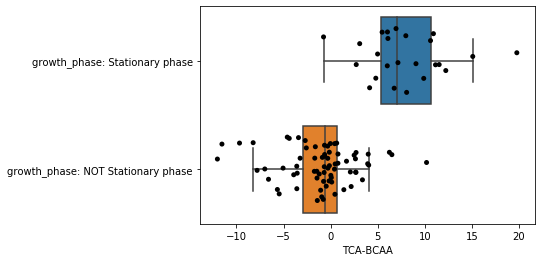

In [106]:
metadata_boxplot(ica_data, 'TCA-BCAA', n_boxes=2)

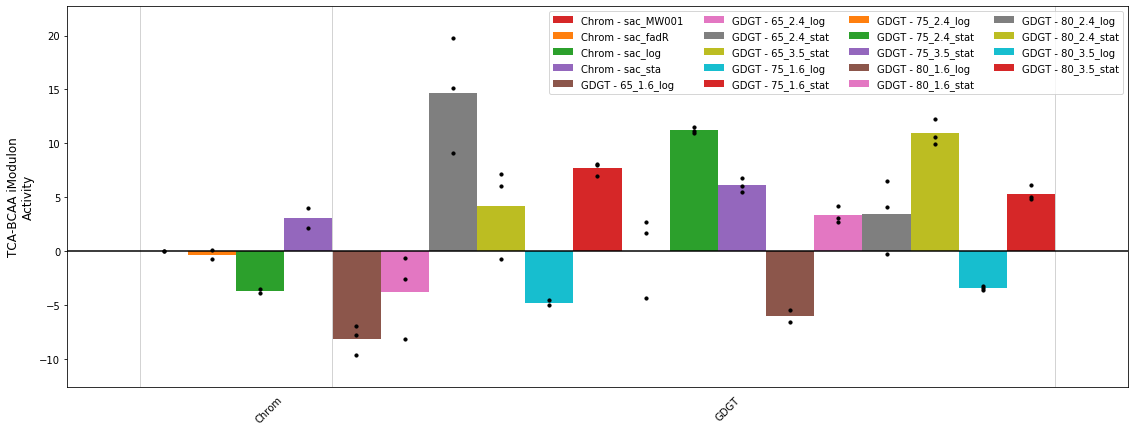

In [107]:
fig, ax = plt.subplots(figsize=(19, 7))

plot_activities(ica_data, 'TCA-BCAA', projects=['Chrom', 'GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

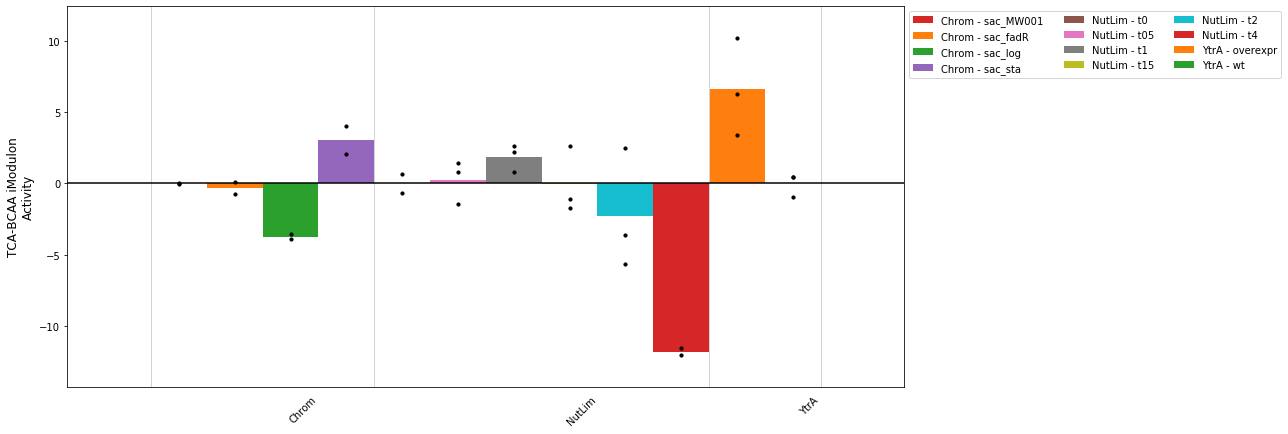

In [108]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'TCA-BCAA', projects=['Chrom', 'NutLim', 'YtrA'],
                highlight=['Chrom', 'NutLim', 'YtrA'], ax=ax)

## To be continued in next notebook